# Implementation of Finite Mixture Model

<details>
  <summary>Table of Contents</summary>
  <ol>
    <li>
      Import Needed Filepaths and Libraries
    </li>
    <li>
    Load Dataset Into Pandas DataFrame
    </li>
    <li>
    Define Response Variable `y`
    </li>
    <li>
    Set Up Reproducible Random Number Generator
    </li>
    <li>
      Setting Up Mixture Model
      <ul>
        <li>Initial Parameters</li>
        <li>Setting Priors</li>
      </ul>
    </li>
    <li>Gibbs Sampler Implementation
      <ul>
        <li>Gibbs Sampler Updates</li>
      </ul>
</li>
  </ol>
</details>

# Implementation of Finite Mixture Model

<details>
  <summary>Table of Contents</summary>

  1. Introduction
     1.1 Background and Motivation
     1.2 Overview of the Finite Mixture Model
     1.3 Application to Congressional District Compactness

  2. Data and Preprocessing
     2.1 Load Dataset Into Pandas DataFrame
     2.2 Prepare Outcome Variable
     2.3 Define Compactness Metrics and Construct Matrix \(X\)
     2.4 Standardize Compactness Metrics
     2.5 Principal Component Analysis (PCA) for Compactness Index
     2.6 Sign Correction of PC1
     2.7 Rescale Compactness Index to \([0,1]\)
     2.8 Store Compactness Index and Define Response \(y\)
     2.9 Define Sample Size \(n\)

  3. Bayesian Mixture Model Specification
     3.1 Scaled Inverse-\(\chi^2\) Sampler
     3.2 Likelihood for the Two-Component Mixture
     3.3 Latent Class Indicators \(z_i\)
     3.4 Prior Distributions
         3.4.1 Priors on Component Means \(\mu_1, \mu_2\)
         3.4.2 Scaled Inverse-\(\chi^2\) Priors on \(\sigma_1^2, \sigma_2^2\)
         3.4.3 Beta Prior on Mixing Weight \(\lambda\)

  4. Initialization
     4.1 Set Up Reproducible Random Number Generator
     4.2 Initialize Mixing Weight \(\lambda\)
     4.3 Initialize Component Means \(\mu_1, \mu_2\)
     4.4 Initialize Component Variances \(\sigma_1^2, \sigma_2^2\)

  5. Gibbs Sampling Algorithm
     5.1 Storage Structures for Posterior Draws
     5.2 Conditional Update for Latent Indicators \(z_i\)
     5.3 Conditional Updates for \(\mu_1, \mu_2\)
     5.4 Conditional Updates for \(\sigma_1^2, \sigma_2^2\)
     5.5 Conditional Update for \(\lambda\)
     5.6 Full Gibbs Sampler Loop (Burn-in and Thinning)

  6. Convergence Diagnostics
     6.1 Gelman–Rubin \(\hat{R}\) Statistics
     6.2 Trace Plots for Key Parameters
     6.3 Effective Sample Size and Autocorrelation Checks

  7. Posterior Summaries
     7.1 Posterior Means of Parameters
     7.2 Posterior Quantiles and Credible Intervals
     7.3 Summary Statistics Table (Mean, SD, Quantiles)

  8. Visualizations of Posterior Distributions
     8.1 Histograms of Posterior Samples
     8.2 Grid of Histograms with Posterior Means and 95% Credible Intervals
     8.3 Additional Density or Overlay Plots

  9. Posterior Predictive Simulation
     9.1 Storage for Posterior Predictive Replicates \(y^{\text{rep}}\)
     9.2 Simulating Replicated Compactness Index Values
     9.3 Histogram: Observed vs Replicated Data
     9.4 QQ Plot for Posterior Predictive Checks
     9.5 Scatterplot of Observed vs Replicated Compactness Index

  10. Application to Gerrymandering
      10.1 Posterior Probability of Gerrymandering by District
      10.2 Label Switching Fix for the Gerrymandered Cluster
      10.3 Add Posterior Probabilities to District-Level Data

  11. Racial Composition and Gerrymandering
      11.1 Racial Composition by Posterior Gerrymandering Cluster
      11.2 Scatter Plots of Posterior Probability vs Racial Variables

  12. Ranking Districts by Posterior Probability
      12.1 Sort Districts from Most to Least Likely Gerrymandered
      12.2 Select Columns to Display
      12.3 Display Top 20 Most Likely Gerrymandered Districts

  13. Discussion and Conclusions
      13.1 Interpretation of Mixture Components
      13.2 Implications for Gerrymandering Analysis
      13.3 Limitations and Future Work

</details>


## Data and Preprocessing

### Import Needed Filepaths and Libraries

In [540]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import norm
from scipy import stats
from texas_gerrymandering_hb4.config import FINAL_CSV, IMAGES_DIR


### Load Dataset Into Pandas DataFrame
Our processed dataset is read into a Pandas DataFrame.

In [541]:
df = pd.read_csv(FINAL_CSV)


### Prepare Outcome Variable
Compactness metrics are a widely-accepted indicator of gerrymandering. The PCA-weighted average of compactness metrics in our dataset, labeled as 'compactness_index' in our Pandas DataFrame, will be the outcome for the mixture. Compactness index values near 1 are considered "compact/not gerrymandered" while values near 0 are labeled "non-compact/gerrymandered".

#### Define Which Columns in DataFrame Contain Compactness Metrics

In [542]:
compactness_cols = [
    "polsby_popper",
    "reock",
    "convex_hull_ratio",
    "schwartzberg",
]

#### Obtain Matrix `X` of Compactness Metrics from DataFrame

In [543]:
X = df[compactness_cols].values

#### Standardizing Compactness Metrics to Mean 0 and Variance 1
* scikit-learn's StandardScaler is fit to the X matrix and then returns standardized data.
* Standardization before PCA implementation is recommended when variables are on different scales.

In [544]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

#### Obtain First Principal Component Scores
* A composite PCA-weighted compactness index is generated from the four compactness metrics in our dataset.
* `pca` is a PCA object that only retains the first principal component.
* `pc1` fits the PCA object to the standardized data and then returns compactness scores on the first component for every district.

In [545]:
pca = PCA(n_components=1)
pc1 = pca.fit_transform(X_std).flatten()

#### Sign Correction of First Principal Component
* PCA is sign-indeterminate.
* To address this, the correlation between the first principal component and the polsby popper value is computed using NumPy.
* If the correlation is negative, then the sign of the first pricipal component is flipped by multiplying by -1.
* By flipping the signs if the correlation is negative, we make sure that the higher first principal component translates to higher compactness, consistent with one of the original compactness metrics.

In [546]:
if np.corrcoef(pc1, df["polsby_popper"].values)[0, 1] < 0:
    pc1 = -pc1

#### Rescale Principal Component 1 to [0,1]
* The minimum and maximum values of the first principal component are computed.
* The compactness index is linearly rescaled to the unit interval [0,1] like this:
$$\text{compactness index}_i
  = \frac{PC1_i - \min(PC1)}{\max(PC1) - \min(PC1)}$$


In [547]:
pc1_min, pc1_max = pc1.min(), pc1.max()
compactness_index = (pc1 - pc1_min) / (pc1_max - pc1_min)

#### Store Compactness Index in DataFrame

In [548]:
df["compactness_index"] = compactness_index

#### Defining Response Variable `y`
* Our newly generated `compactness_index` becomes our response variable `y_{i}` in our finite mixture model.

In [549]:
y = df["compactness_index"].values

#### Defining Sample Size
* `n` denotes the sample size, which is the number of Congressional districts in Texas (38).

In [550]:
n = len(y)

## Finite Mixture Model Specification

### Scaled Inverse-$\chi^2$ Sampler
* `rinvchisq` is a function that draws from a scaled inverse-$\chi^2$ distribution.
* This is the conjugate prior for the variance in the normal model.
* This will be used to update $\sigma_1^2$ and $\sigma_2^2$ in the Gibbs sampler.

In [551]:
def rinvchisq(df, scale):
    return df * scale / np.random.chisquare(df)


### Setting Priors

#### Setting Priors for $\lambda$: $\alpha_1$ and $\alpha_2$
* `alpha_1` and `alpha_2` are the priors for lambda.
$$\lambda \sim Beta(\alpha_1, \alpha_2)$$
Because the prior for lambda is Beta(2,2), `alpha_1` and `alpha_2` are both set to 2.
* This is a conjugate prior. Also, as a reminder, Beta(2,2) is also a Dirchilet distribution. What is beneficial about this is that the probability of obtaining 0 or 1, which is a degenerate model, is 0. Hence, as you get closer to 0 or 1, the likelihood is tiny. As a result, the problem is pushed further away from a degenerate value, so they become less likely to accidently become a point of convergence.

In [552]:
alpha_1 = 2.0
alpha_2 = 2.0

#### Setting Priors for Means: $\mu_1$ and $\mu_2$
* The means `m0_1` and `mu0_2` are coming from the same distribution.
* Keep in mind that compactness index is between 0 and 1.
* The prior means $\mu_1$ and $\mu_2$ are set to 0.5; after all, "Bayesian Data Analysis" (Third Edition) typically sets its priors in the middle of the plausible range, which is between 0 and 1 in this case.

In [553]:
mu0_1 = 0.5
mu0_2 = 0.5

#### Setting Priors for Variances: $\sigma_1^2$ and $\sigma_2^2$
* The prior scales for $\sigma_1^2$ and $\sigma_2^2$ are set to $0.25^2=0.0625$.
* Again, we are setting weakly informative priors between the range of 0 and 1.

In [554]:
sigma_0_squared_1 = 0.25**2
sigma_0_squared_2 = 0.25**2

#### Setting Priors for Degrees of Freedom
* We set the prior degrees of freedom for the inverse-$\chi^2$ sampler to 2.
* Again, this is a weakly informative prior.
* Chapter 3 in "Bayesian Data Analysis" (Third Edition) states that the degrees of freedom are small when prior information on the variance is vague.

In [555]:
degrees_of_freedom0_1 = 2
degrees_of_freedom0_2 = 2

## Initialization

### Set Up Reproducible Random Number Generator
* A random seed is set so the Gibbs sampler and posterior predictive draws are reproducible.

In [556]:
np.random.seed(123)

### Initial Parameters
* These parameters represent starting guesses for the Gibbs sampler.

#### Initialize $\lambda$
`lambda` ($\lambda$) is the mixing proportion. Starting from a place of ignorance, we assume a perfect mix between the two, and that our means are the sample means and our variances are the sample variances. $\lambda$ is set to 0.5 to serve as a neutral initial guess.

In [557]:
_lambda = 0.5

#### Initialize Means: $\mu_1$ and $\mu_2$
* `mu_1` and `mu_2` represent the initial means for each component.
* Initial parameters based on the data help circumvent warmup challenges.
* This is a neutral starting pint when you're not sure which component is which.

In [558]:
mu_1 = np.mean(y)
mu_2 = np.mean(y)

#### Initialize Variances: $\sigma^2_1$ and $\sigma^2_2$
* `sigma_squared_1` and `sigma_squared_2` are initialized to the sample variance of `y`.
* Again, "Bayesian Data Analysis" (Third Edition) encourages initial parameters based on data.

In [559]:
sigma_squared_1 = np.var(y,ddof=1)
sigma_squared_2 = np.var(y, ddof=1)

## Gibbs Sampling
* The process for the Gibbs sampler involves initializing parameters, iterative sampling, and continuing the iterations until convergence.
* The benefits of the Gibbs sampler are that it handles complex, high-dimensional distributions and is easier to implement than direct sampling methods.

### Gibbs Sampler Parameters
* The Gibbs sampler runs for 20000 iterations and discards the first 10000 iterations as warmup.

In [560]:
iterations = 20000
warmup = 10000

### Storage Structures for Posterior Draws

In [561]:
lambda_samples = np.zeros(iterations)
mu1_samples = np.zeros(iterations)
mu2_samples = np.zeros(iterations)
sigma_squared_1_samples = np.zeros(iterations)
sigma_squared_2_samples = np.zeros(iterations)
z_samples = np.zeros((iterations, n), dtype=int)

### Gibbs Sampler Implementation

In [562]:
for i in range(iterations):

    # Updating z.
    # Data augmentation is implemented here.
    lik_1 = _lambda * norm.pdf(y, loc=mu_1, scale=np.sqrt(sigma_squared_1))
    lik_2 = (1 - _lambda) * norm.pdf(y, loc=mu_2, scale=np.sqrt(sigma_squared_2))
    z_probs = lik_1 / (lik_1 + lik_2)
    z = np.random.binomial(1, z_probs)

    # Updating lambda.
    alpha_lambda_post = alpha_1 + np.sum(z)
    beta_lambda_post = alpha_2 + (n - np.sum(z))
    _lambda = np.random.beta(alpha_lambda_post, beta_lambda_post)

    # Updating mu 1.
    n1 = np.sum(z)
    if n1 > 0:
        y1_mean = np.mean(y[z == 1])
        mu1_post_mean = ((mu0_1 / sigma_0_squared_1) + n1 * y1_mean / sigma_squared_1) / \
                        (1 / sigma_0_squared_1 + n1 / sigma_squared_1)
        mu1_post_sd = np.sqrt(1 / (1 / sigma_0_squared_1 + n1 / sigma_squared_1))
    else:
        mu1_post_mean = mu0_1
        mu1_post_sd = np.sqrt(sigma_0_squared_1)
    mu_1 = np.random.normal(mu1_post_mean, mu1_post_sd)

    # Updating mu 2.
    n2 = n - n1
    if n2 > 0:
        y2_mean = np.mean(y[z == 0])
        mu2_post_mean = ((mu0_2 / sigma_0_squared_2) + n2 * y2_mean / sigma_squared_2) / \
                        (1 / sigma_0_squared_2 + n2 / sigma_squared_2)
        mu2_post_sd = np.sqrt(1 / (1 / sigma_0_squared_2 + n2 / sigma_squared_2))
    else:
        mu2_post_mean = mu0_2
        mu2_post_sd = np.sqrt(sigma_0_squared_2)
    mu_2 = np.random.normal(mu2_post_mean, mu2_post_sd)

    # Updating sigma squared 1.
    nu1_post = degrees_of_freedom0_1 + n1
    if n1 > 0:
        ss1 = np.sum((y[z == 1] - mu_1) ** 2)
    else:
        ss1 = 0.0
    sigma1_post_scale = (degrees_of_freedom0_1 * sigma_0_squared_1 + ss1) / nu1_post
    sigma_1_sq = rinvchisq(nu1_post, sigma1_post_scale)

    # Updating sigma squared 2.
    nu2_post = degrees_of_freedom0_2 + n2
    if n2 > 0:
        ss2 = np.sum((y[z == 0] - mu_2) ** 2)
    else:
        ss2 = 0.0
    sigma2_post_scale = (degrees_of_freedom0_2 * sigma_0_squared_2 + ss2) / nu2_post
    sigma_2_sq = rinvchisq(nu2_post, sigma2_post_scale)
    sigma_squared_1 = sigma_1_sq
    sigma_squared_2 = sigma_2_sq

    # Address label switching issue.
    # Make sure component 1 is always the cluster with lower compactness.
    if mu_1 > mu_2:
        # Switch the means.
        mu_1, mu_2 = mu_2, mu_1
        # Switch the variances.
        sigma_squared_1, sigma_squared_2 = sigma_squared_2, sigma_squared_1
        sigma_1_sq, sigma_2_sq = sigma_2_sq, sigma_1_sq
        # Label lambda again.
        _lambda = 1.0 - _lambda
        # Label z again.
        z = 1 - z

    # Save draws in storage arrays.
    lambda_samples[i] = _lambda
    mu1_samples[i] = mu_1
    mu2_samples[i] = mu_2
    sigma_squared_1_samples[i] = sigma_1_sq
    sigma_squared_2_samples[i] = sigma_2_sq
    z_samples[i, :] = z


## Convergence Diagnostics

### Discard Warmup Draws and Define Post-Warmup Samples

In [563]:
lambda_post = lambda_samples[warmup:]
mu1_post = mu1_samples[warmup:]
mu2_post = mu2_samples[warmup:]
sigma1_post = sigma_squared_1_samples[warmup:]
sigma2_post = sigma_squared_2_samples[warmup:]
z_post = z_samples[warmup:, :]

### Estimate $\hat{R}$
* Page 284 of "Bayesian Data Analysis" (Third Edition) asserts that convergence is assessed by checking mixing and stationarity.
* We accomplish this by splitting each chain in half and check that all the resulting half sequences have mixed.
* We must assess mixing using "between- and within-sequence variances". For every scalar estimand $\psi$, we label the simulations as $\psi_{ij}(i=1, \cdots, n;j=1, \cdots,m)$, and we compute B and W, the between- and within-sequence variances:
$$B = \frac{n}{m-1} \sum_{j=1}^m (\bar{\psi}_{\cdot j} - \bar{\psi}_{\cdot \cdot})^2,
\qquad \text{where }
\bar{\psi}_{\cdot j} = \frac{1}{n} \sum_{i=1}^n \psi_{ij},
\quad
\bar{\psi}_{\cdot \cdot} = \frac{1}{m} \sum_{j=1}^m \bar{\psi}_{\cdot j}$$
$$W = \frac{1}{m} \sum_{j=1}^m s_j^2,
\qquad \text{where }
s_j^2 = \frac{1}{n-1} \sum_{i=1}^n (\psi_{ij} - \bar{\psi}_{\cdot j})^2$$
* According to page 285 in "Bayesian Data Analysis" (Third Edition), convergence of the Gibbs sampler iterative simulation is monitored via estimation of the factor by which the scale of the current $\psi$ distribution might be reduced if the simulations were continued in the limit $n \to \infty$.
* The potential scale reduction $\hat{R}$, according to "Bayesian Data Analysis" (Third Edition), is estimated via
$$\hat{R} = \sqrt{\frac{\hat{var}^{+} (\psi|y)}{W}}$$
which declines to 1 as $n \to \infty$.
* Page 285 says that if $\hat{R}$ is high, then we can draw the conclusion that performing more simulations may improve our inference.

In [564]:
def split_rhat(x):

    x = np.asarray(x)
    S = x.shape[0]
    if S < 20:
        raise ValueError("Need at least 20 post-warmup draws for R-hat.")
    # Make sure sequence chains are same length.
    if S % 2 == 1:
        x = x[:-1]
        S -= 1
    half = S // 2
    # Take each of the chains and split into first and second half.
    chains = np.stack([x[:half], x[half:]], axis=0)  # shape (m=2, n=half)
    m, n = chains.shape

    chain_means = chains.mean(axis=1)
    chain_vars = chains.var(axis=1, ddof=1)
    mean_overall = chain_means.mean()

    # Compute between-sequence variance (B).
    B = n * ((chain_means - mean_overall) ** 2).sum() / (m - 1)
    # Compute within-sequence variance (W).
    W = chain_vars.mean()

    # Compute R hat.
    var_hat = (n - 1) / n * W + B / n
    Rhat = np.sqrt(var_hat / W)
    return Rhat

print("Split R-hat diagnostics (values close to 1 indicate convergence):")
for name, samples in [
    ("lambda",     lambda_post),
    ("mu_1",       mu1_post),
    ("mu_2",       mu2_post),
    ("sigma_1_sq", sigma1_post),
    ("sigma_2_sq", sigma2_post),
]:
    print(f"{name:10s}: R-hat = {split_rhat(samples):.3f}")


Split R-hat diagnostics (values close to 1 indicate convergence):
lambda    : R-hat = 1.000
mu_1      : R-hat = 1.000
mu_2      : R-hat = 1.000
sigma_1_sq: R-hat = 1.000
sigma_2_sq: R-hat = 1.000


### Generate Trace Plots of Key Parameters

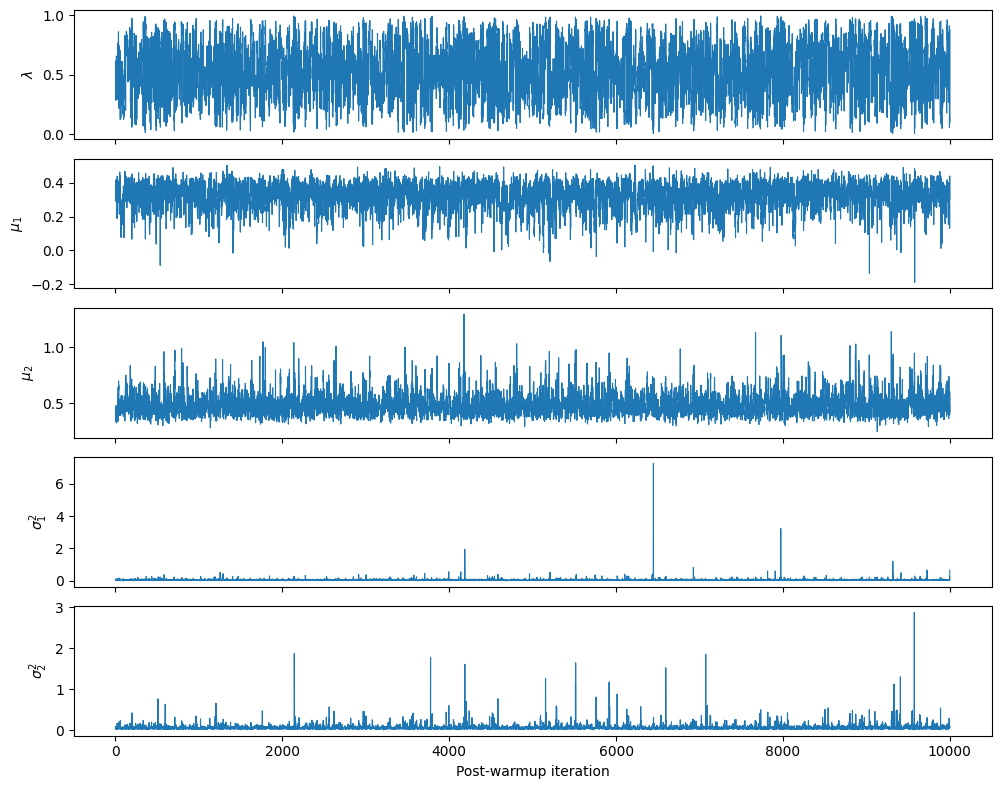

In [565]:
fig, axes = plt.subplots(5, 1, figsize=(10, 8), sharex=True)
trace_series = [
    (r"$\lambda$",    lambda_post),
    (r"$\mu_1$",      mu1_post),
    (r"$\mu_2$",      mu2_post),
    (r"$\sigma_1^2$", sigma1_post),
    (r"$\sigma_2^2$", sigma2_post),
]

for ax, (name, samples) in zip(axes, trace_series):
    ax.plot(samples, linewidth=0.8)
    ax.set_ylabel(name)

axes[-1].set_xlabel("Post-warmup iteration")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "traceplots_mixture_params.png")
plt.show()

## Posterior Summaries

### Posterior Means of Parameters
* Computes and prints posterior means for $\lambda$, $\mu_1$, $\mu_2$, $\sigma_1^2$, and $\sigma_2^2$.

In [566]:
print("Posterior mean lambda:", lambda_post.mean())
print("Posterior mean mu_1 (compactness):", mu1_post.mean())
print("Posterior mean mu_2 (compactness):", mu2_post.mean())
print("Posterior mean sigma1^2:", sigma1_post.mean())
print("Posterior mean sigma2^2:", sigma2_post.mean())


Posterior mean lambda: 0.5476019791155089
Posterior mean mu_1 (compactness): 0.3206223714323012
Posterior mean mu_2 (compactness): 0.48973519680486205
Posterior mean sigma1^2: 0.05487967096974587
Posterior mean sigma2^2: 0.06307529645101484


### Generate Python Dictionary of Posterior Quantiles

In [567]:
def summarize_posterior(samples):
    samples = np.asarray(samples)
    return {
        "mean": float(np.mean(samples)),
        "sd": float(np.std(samples, ddof=1)),
        "2.5%": float(np.quantile(samples, 0.025)),
        "25%": float(np.quantile(samples, 0.25)),
        "50%": float(np.quantile(samples, 0.50)),
        "75%": float(np.quantile(samples, 0.75)),
        "97.5%": float(np.quantile(samples, 0.975)),
    }

### Summary Statistics Table

In [568]:
summary_stats = pd.DataFrame.from_dict(
    {
        "lambda":    summarize_posterior(lambda_post),
        "mu_1":      summarize_posterior(mu1_post),
        "mu_2":      summarize_posterior(mu2_post),
        "sigma_1_sq": summarize_posterior(sigma1_post),
        "sigma_2_sq": summarize_posterior(sigma2_post),
    },
    orient="index"
)

summary_stats


,mean,sd,2.5%,25%,50%,75%,97.5%
lambda,0.547602,0.235186,0.100607,0.367003,0.558254,0.738044,0.935737
mu_1,0.320622,0.075983,0.136792,0.281069,0.333937,0.373154,0.434512
mu_2,0.489735,0.096309,0.355716,0.423355,0.470989,0.536694,0.728180
sigma_1_sq,0.054880,0.090091,0.018617,0.034858,0.045935,0.060934,0.133231
sigma_2_sq,0.063075,0.076001,0.018595,0.035804,0.049379,0.068662,0.189345


## Visualizations of Posterior Distributions

### Histograms of Posterior Samples
* First, we prepare a grid with dimensions 2x3 To display posterior distributions for $\lambda, \mu_1, \mu_2, \sigma_1^2, \sigma_2^2$.
* Then, we plot posterior histograms with overlays for the mean and upper/lower bounds of 95% credibility intervals.
* Finally, we clean up the grid by removing unused histogram plots then proceed to show the plot and save histograms grid.

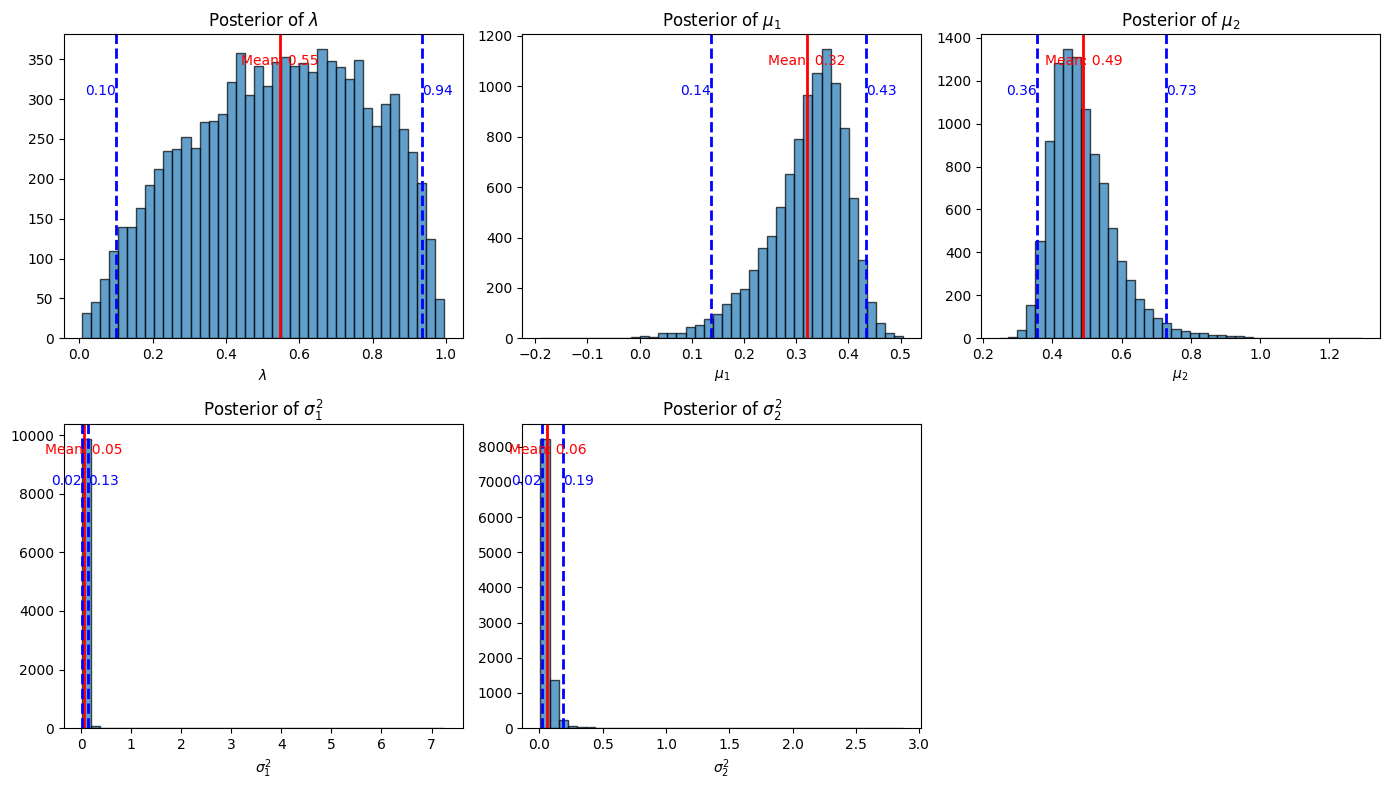

In [569]:
posteriors = [
    (r"$\lambda$",    lambda_post),
    (r"$\mu_1$",      mu1_post),
    (r"$\mu_2$",      mu2_post),
    (r"$\sigma_1^2$", sigma1_post),
    (r"$\sigma_2^2$", sigma2_post),
]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for ax, (name, samples) in zip(axes, posteriors):
    # Create histograms.
    ax.hist(samples, bins=40, edgecolor="black", alpha=0.7)

    # Plot posterior means.
    mean_val = samples.mean()
    ax.axvline(mean_val, color="red", linewidth=2, label="Mean")

    # Obtain upper and lower bounds 95% credibility interval.
    lower = np.quantile(samples, 0.025)
    upper = np.quantile(samples, 0.975)

    ax.axvline(lower, color="blue", linestyle="--", linewidth=2, label="95% CI")
    ax.axvline(upper, color="blue", linestyle="--", linewidth=2)

    # Add labels and titles to plot.
    ymax = ax.get_ylim()[1]

    ax.text(mean_val, ymax * 0.90, f"Mean: {mean_val:.2f}",
            color="red", ha="center")

    ax.text(lower, ymax * 0.80, f"{lower:.2f}",
            color="blue", ha="right")

    ax.text(upper, ymax * 0.80, f"{upper:.2f}",
            color="blue", ha="left")

    ax.set_title(f"Posterior of {name}")
    ax.set_xlabel(name)

    # Get rid of any histogram plot that is unused.
for j in range(len(posteriors), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(IMAGES_DIR/"histograms_posterior_samples.png")
plt.show()

## Posterior Predictive Simulation

### Storage for Posterior Predictive Replications $y^{rep}$
* We obtain the number of post-warmup iterations (`S`) and sample size (`n`).
* `y_rep` is an array we create to store the posterior predictive replications $y_{i}^{rep(s)}$.

In [570]:
S = len(lambda_post)
n = len(y)

y_rep = np.zeros((S, n))

### Simulating Replicated Compactness Index Values

In [571]:
for s in range(S):
    mu1_s = mu1_post[s]
    mu2_s = mu2_post[s]
    sigma1_s = np.sqrt(sigma1_post[s])  # convert variances to std devs
    sigma2_s = np.sqrt(sigma2_post[s])

    # latent class labels for iteration s
    z_s = z_post[s, :]          # shape (n,), values 0 or 1

    # indices for each component
    idx1 = (z_s == 1)
    idx2 = ~idx1

    # simulate replicated data for each component
    if idx1.any():
        y_rep[s, idx1] = np.random.normal(
            loc=mu1_s,
            scale=sigma1_s,
            size=idx1.sum()
        )
    if idx2.any():
        y_rep[s, idx2] = np.random.normal(
            loc=mu2_s,
            scale=sigma2_s,
            size=idx2.sum()
        )


### Histogram of Observed vs Replicated Data

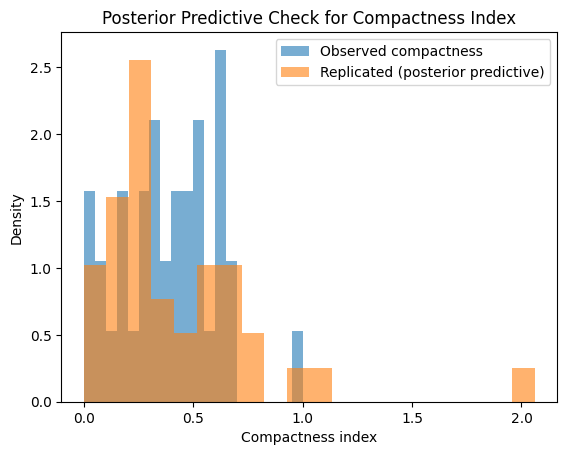

In [572]:
# %%
# Take one replicated dataset (e.g., last iteration) for a simple overlay
y_rep_single = y_rep[-1, :]

plt.hist(y, bins=20, density=True, alpha=0.6, label="Observed compactness")
plt.hist(y_rep_single, bins=20, density=True, alpha=0.6, label="Replicated (posterior predictive)")
plt.xlabel("Compactness index")
plt.ylabel("Density")
plt.title("Posterior Predictive Check for Compactness Index")
plt.legend()
plt.show()

### QQ Plot for Posterior Predictive Checks
A QQ plot is generated for a single draw of predictive replicated data $y^{rep}$.

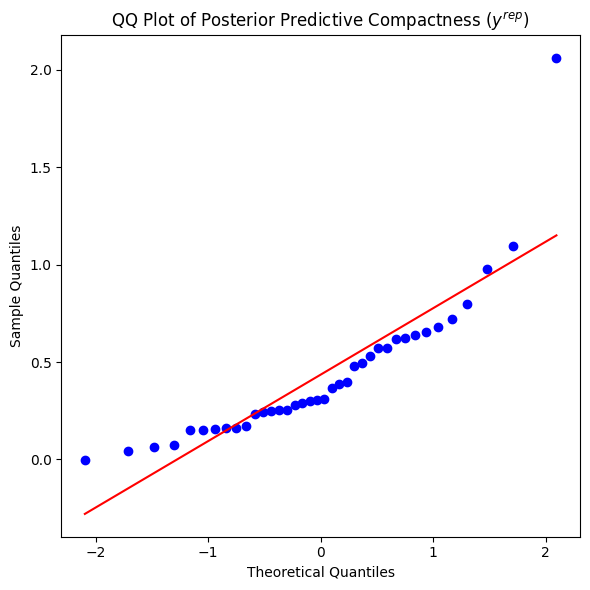

In [573]:
plt.figure(figsize=(6, 6))
stats.probplot(y_rep_single, dist="norm", plot=plt)
plt.title("QQ Plot of Posterior Predictive Compactness ($y^{rep}$)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.tight_layout()
plt.savefig(IMAGES_DIR/"mixture_model_qq_plot.png")
plt.show()

### Scatterplot of Observed vs Posterior Replicated Compactness Index
* We plot observed y versus one posterior predictive replicate $y^{rep}$.
* If the model fits well, points should cluster around the line.

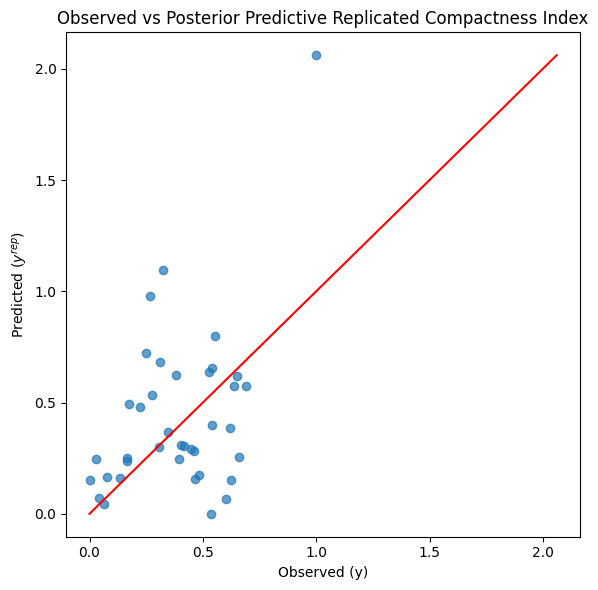

In [574]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_rep_single, alpha=0.7)

# Create a 45-degree reference line.
min_val = min(y.min(), y_rep_single.min())
max_val = max(y.max(), y_rep_single.max())
plt.plot([min_val, max_val], [min_val, max_val], color="red")

plt.xlabel("Observed (y)")
plt.ylabel("Predicted ($y^{rep}$)")
plt.title("Observed vs Posterior Predictive Replicated Compactness Index")
plt.tight_layout()
plt.savefig(IMAGES_DIR/"mixture_model_observed_vs_predicted.png")
plt.show()

## Application to Gerrymandering

### Label Switching Fix

In [575]:
is_low1 = mu1_post < mu2_post

In [576]:
gerr_label_per_iter = np.where(is_low1, 1, 0)

In [577]:
post_prob_geom_gerr = np.mean(
    z_post == gerr_label_per_iter[:, None],
    axis=0
)

In [578]:
df["post_prob_geom_gerrymandered"] = post_prob_geom_gerr

# For backward compatibility with your previous code name:
df["post_prob_gerrymandered"] = df["post_prob_geom_gerrymandered"]

In [579]:
df[["district_id", "compactness_index", "post_prob_gerrymandered"]].head()

,district_id,compactness_index,post_prob_gerrymandered
0,1,0.403531,0.5485
1,2,0.305874,0.6130
2,3,0.417277,0.5372
3,4,0.061802,0.7213
4,5,0.393908,0.5612


## Racial Composition and Gerrymandering

In [580]:
race_cols = [
    "pct_white",
    "pct_black",
    "pct_hispanic",
    "pct_asian",
    "pct_native",
    "pct_other",
]

In [581]:
# Keep only the race_cols that are actually present in the DataFrame
race_cols = [c for c in race_cols if c in df.columns]

if not race_cols:
    raise ValueError("No racial composition columns found in df. "
                     "Check that pct_white / pct_black / pct_hispanic, etc., exist.")

In [582]:
# Create a binary indicator for districts with high posterior probability of being gerrymandered.
# Here we use a 0.5 threshold; you can adjust if you want to be more strict (e.g. 0.7).
df["gerr_cluster"] = (df["post_prob_gerrymandered"] >= 0.5).astype(int)

In [583]:
# Make the definition explicit:
# gerr_cluster = 1 -> high posterior probability of gerrymandering
# gerr_cluster = 0 -> low posterior probability
cluster_labels = {0: "Low posterior P(gerrymandered)", 1: "High posterior P(gerrymandered)"}

In [584]:
# Compute mean racial composition within each cluster
race_means = df.groupby("gerr_cluster")[race_cols].mean().T

<Figure size 1000x600 with 0 Axes>

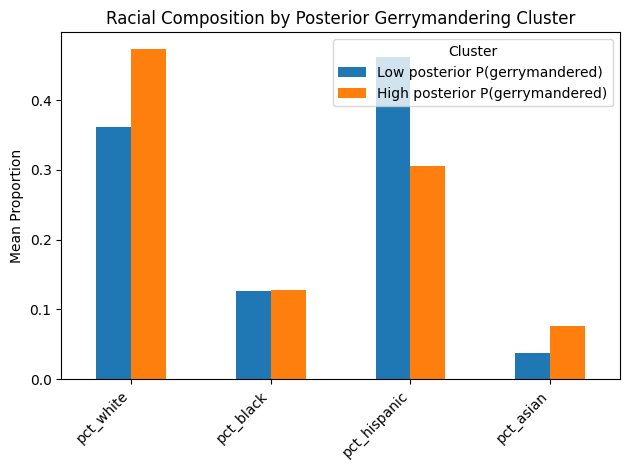

In [585]:
plt.figure(figsize=(10, 6))
race_means.plot(kind="bar")
plt.ylabel("Mean Proportion")
plt.title("Racial Composition by Posterior Gerrymandering Cluster")
plt.xticks(rotation=45, ha="right")

# Replace legend labels with more interpretable text
handles, labels = plt.gca().get_legend_handles_labels()
labels = [cluster_labels[int(l)] for l in labels]
plt.legend(handles, labels, title="Cluster", loc="best")

plt.tight_layout()
plt.show()


### Scatter Plot of Probability of Gerrymandering vs. Race

In [586]:
def plot_post_prob_vs_race(race_col, label=None):
    if race_col not in df.columns:
        print(f"Column {race_col} not found in df; skipping.")
        return

    plt.figure(figsize=(8, 6))
    plt.scatter(df[race_col], df["post_prob_gerrymandered"], alpha=0.7)
    plt.xlabel(label if label is not None else race_col)
    plt.ylabel("Posterior P(geometric gerrymandering)")
    plt.title(f"Posterior Gerrymandering Probability vs {label or race_col}")
    plt.tight_layout()
    plt.show()

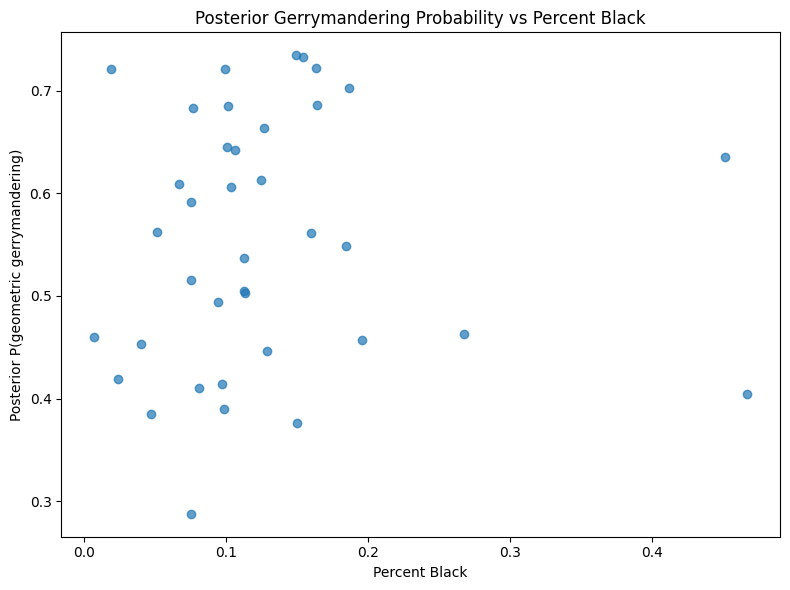

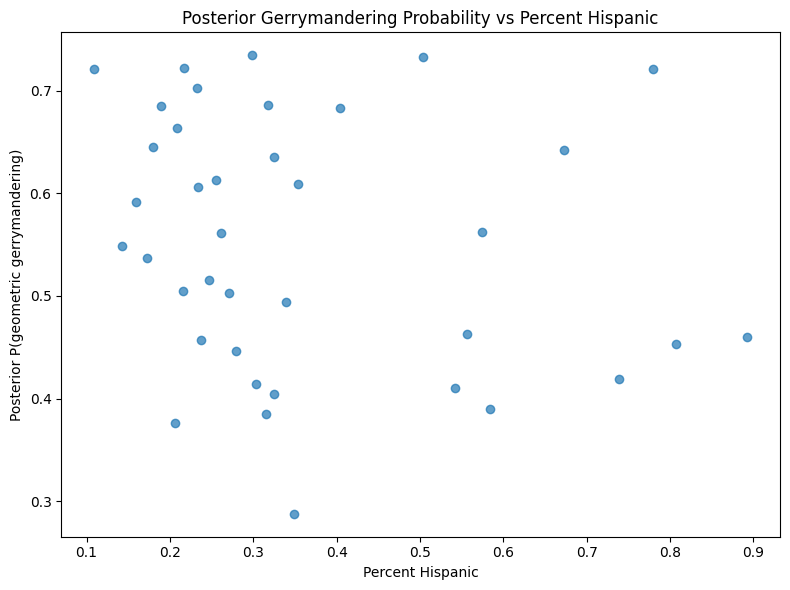

In [587]:
# Example: plots for percent Black and percent Hispanic
plot_post_prob_vs_race("pct_black", label="Percent Black")
plot_post_prob_vs_race("pct_hispanic", label="Percent Hispanic")


## Ranking Districts By Posterior Probability

### Sort Districts from Most Likely to Least Likely to Be Gerrymandered

In [588]:
df_sorted = df.sort_values("post_prob_gerrymandered", ascending=False)

### Choose Columns to Include

In [589]:
cols_to_show = [
    "district_id",
    "compactness_index",
    "post_prob_gerrymandered",
]

In [590]:
# Optional columns – only include if they’re actually present
for c in ["pct_minority", "dem_share"]:
    if c in df_sorted.columns:
        cols_to_show.append(c)

### Show 20 Districts with the Highest Probability of Being Gerrymandered

In [591]:
df_sorted[cols_to_show].head(20)

,district_id,compactness_index,post_prob_gerrymandered,dem_share
6,7,0.000000,0.7346,0.632036
32,33,0.028250,0.7333,0.688378
13,14,0.040070,0.7219,0.389740
14,15,0.078903,0.7213,0.445939
3,4,0.061802,0.7213,0.405732
35,36,0.134082,0.7030,0.387174
7,8,0.165469,0.6859,0.388563
9,10,0.165394,0.6849,0.393264
26,27,0.174912,0.6833,0.415234
31,32,0.222402,0.6636,0.457105
